Parkinson Prediction using Random Forest

In [5]:
import os,sys
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, RocCurveDisplay
from sklearn.metrics import classification_report, balanced_accuracy_score, ConfusionMatrixDisplay, make_scorer
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import matplotlib.pyplot as plt

sys.path.append("/Users/veenabalakrishnan/Desktop/Prep/ERDOS_BOOTCAMP/Project/summer-2025-parkinsonpredict/src")  # adjust path as needed
from data_loader import LoadData

In [12]:
mri_data_path = "/Users/veenabalakrishnan/Desktop/Prep/ERDOS_BOOTCAMP/Project/ParkinsonPredict/PDMRI_Clean_Merged_6_13_25.csv"
gene_data_path = "/Users/veenabalakrishnan/Desktop/Prep/ERDOS_BOOTCAMP/Project/ParkinsonPredict/gene_expression_summary.csv"
nhy_latest_path = "/Users/veenabalakrishnan/Desktop/Prep/ERDOS_BOOTCAMP/Project/ParkinsonPredict/clean_mds_updrs.csv"

dataload_mri_cls = LoadData(input_updrs=nhy_latest_path,
    input_gene_clinical=gene_data_path,
    input_mri=mri_data_path,
    mri_data=True,
    gene_data=True,
    group_NHY=True,
    group_binary=True,
    common_dataset=True,
    stratify_splits=True)

X_data, Y_data = dataload_mri_cls.merged_data()

X shape: (712, 110), Y shape: (712, 1)
Y class distribution: {(1.0,): 434, (0.0,): 278}


Random Forest

In [13]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X_data, Y_data, test_size=0.2, stratify=Y_data, random_state=42
)
pipeline = ImbPipeline([
    ("scale", StandardScaler()),
    ("smote", SMOTE(random_state=42)),
    ("rf", RandomForestClassifier(n_estimators=200, class_weight="balanced", random_state=42))
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(
    pipeline, X_train, Y_train,
    cv=cv,
    scoring=make_scorer(balanced_accuracy_score),
    n_jobs=-1
)

print(f"CV balanced accuracy (train): {scores.mean():.3f} ± {scores.std():.3f}")

/Users/veenabalakrishnan/miniconda_latest/lib/python3.13/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/veenabalakrishnan/miniconda_latest/lib/python3.13/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/veenabalakrishnan/miniconda_latest/lib/python3.13/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/veenabalakrishnan/miniconda_latest/lib/python3.13/site-packages/sklearn/base.py:1389: DataConversionWarni

CV balanced accuracy (train): 0.546 ± 0.044


ROC CURVE

/Users/veenabalakrishnan/miniconda_latest/lib/python3.13/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


ROC-AUC: 0.708


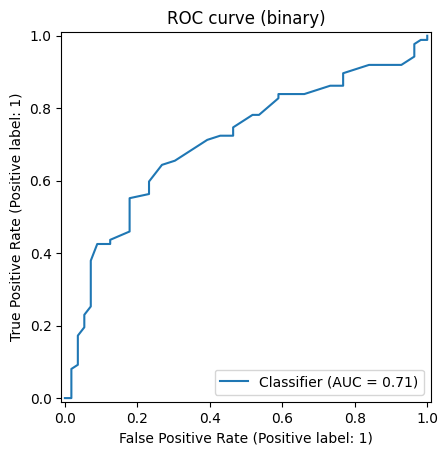

Balanced Accuracy: 0.6350574712643677
                  precision    recall  f1-score   support

Asymptomatic (0)       0.58      0.50      0.54        56
          PD (1)       0.71      0.77      0.74        87

        accuracy                           0.66       143
       macro avg       0.64      0.64      0.64       143
    weighted avg       0.66      0.66      0.66       143



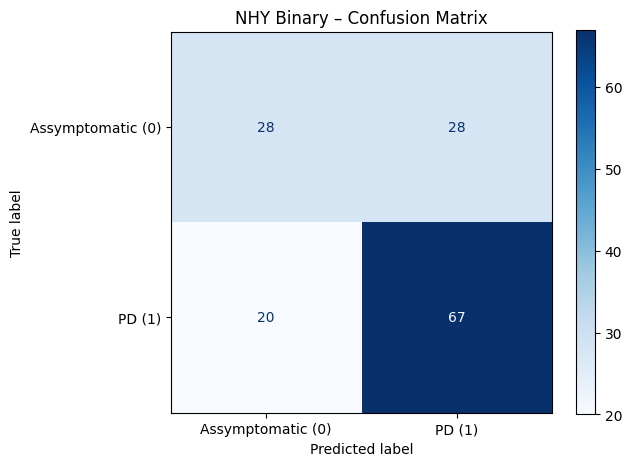

In [17]:
pipeline.fit(X_train, Y_train)
Y_pred = pipeline.predict(X_test)
Y_prob = pipeline.predict_proba(X_test)[:, 1]   
roc_auc = roc_auc_score(Y_test, Y_prob)

print(f"ROC-AUC: {roc_auc:.3f}")

# Optional: plot ROC curve
RocCurveDisplay.from_predictions(Y_test, Y_prob)
plt.title("ROC curve (binary)")
plt.show()

# Evaluate
print("Balanced Accuracy:", balanced_accuracy_score(Y_test, Y_pred))
print(classification_report(Y_test, Y_pred, target_names=["Asymptomatic (0)", "PD (1)"]))

# Plot confusion matrix
ConfusionMatrixDisplay.from_predictions(Y_test, Y_pred, display_labels=["Assymptomatic (0)", "PD (1)"], cmap="Blues")
plt.title("NHY Binary – Confusion Matrix")
plt.tight_layout()
plt.show()